**<font color = black size=6>实验十：卷积神经网络</font>**

这次实验课分两周完成，部分实验内容涉及下周的理论课，同学们可继续熟悉pytorch框架

**<font color = blue size=4>第一部分:卷积神经网络介绍</font>**

输入尺寸为m$\times$n,卷积核大小为f,步幅为s,填充为p,则输出尺寸为$\lfloor \frac{m+2p-f}{s}+1 \rfloor$ $\times$ $\lfloor \frac{n+2p-f}{s}+1 \rfloor$  

$$( m \times n )* ( f \times f ) = \lfloor \frac{m+2p-f}{s}+1 \rfloor \times \lfloor \frac{n+2p-f}{s}+1 \rfloor$$  
例子:输入尺寸为6$\times$6,卷积核大小为f,步幅默认为1,填充为0,则输出尺寸为$\lfloor \frac{6+2\times0-3}{1}+1 \rfloor$ $\times$ $\lfloor \frac{6+2\times0-3}{1}+1 \rfloor$=$4\times4$

卷积层的运算方式

In [1]:
import torch
import torch.nn  as  nn

def conv_calculate(X,K):
    h,w=K.shape
    Y=torch.zeros((X.shape[0]-h+1,X.shape[1]-w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j]=(X[i:i+h ,j:j+w]*K).sum()
    return Y
#X是进入卷积层的原始数据
X=torch.tensor([[0.0,1.0,0.0,0.0,1.0,0.0],
                [0.0,1.0,0.0,0.0,0.0,1.0],
                [0.0,1.0,0.0,0.0,0.0,0.0],
                [0.0,1.0,0.0,0.0,1.0,1.0],
                [0.0,1.0,0.0,0.0,0.0,1.0],
                [0.0,1.0,0.0,0.0,1.0,1.0]])
#K是卷积核，即卷积层的参数之一
K=torch.tensor([[1.0,0.0,-1.0],
                [1.0,0.0,-1.0],
                [1.0,0.0,-1.0]])
#conv_calculate(X,K)即X经过该卷积核进行运算完成后得到的结果
print(conv_calculate(X,K))

tensor([[ 0.,  3., -1., -1.],
        [ 0.,  3., -1., -2.],
        [ 0.,  3., -1., -2.],
        [ 0.,  3., -2., -3.]])


手动实现二维卷积层

In [ ]:
class Conv2D(nn.Module):
    def __init__(self,kernel_size):
        super().__init__()
        #kernel_size:卷积核大小
        self.weight = nn.Parameter(torch.rand(kernel_size))
        #偏置
        self.bias   = nn.Parameter(torch.zeros(1))
    def forward(self,x):
        return conv_calculate(x,self.weight)+self.bias

Pytorch中实现卷积层

In [ ]:
#输入的通道数目（必须设置的参数）
in_channels=1
#输出的通道数目（必须设置的参数）
out_channels=1
#卷积核大小（必须设置的参数）
kernel_size=3
#其余参数皆为可选的参数，如stride代表步幅，padding代表填充，后面会进行介绍
pytorch_conv2d=nn.Conv2d(in_channels, out_channels, kernel_size, stride=1,padding=0)

#初始化该卷积层后，会自动随机分配参数。可以输出其中的参数
print(pytorch_conv2d.state_dict())
#这里我们生成输入数据R1
R1=torch.tensor([[1.0,2.0,3.0,4.0,5.0,6.0],
                 [2.0,3.0,4.0,5.0,6.0,7.0],
                 [3.0,4.0,5.0,6.0,7.0,8.0],
                 [4.0,5.0,6.0,7.0,8.0,9.0],
                 [5.0,6.0,7.0,8.0,9.0,10.0],
                 [6.0,7.0,8.0,9.0,10.0,11.0]])
#reshape函数：将数据转换为指定维度以及大小的数据
#这里使用reshape函数是由于卷积函数的输入必须是四维数据
#其中第一个维度代表着批量大小，第二个维度代表着输入通道数。这里由于我们的X为单通道的一个样本，所以两个维度的参数值均设置为1
R1=R1.reshape((1,1,6,6))
#将数据R1通过该网络，得到输出数据R2
R2=pytorch_conv2d(R1)
print(R2,R2.shape)

卷积层的简单应用：检测图像中不同颜色的边缘

In [ ]:
X=torch.tensor([[10.0,10.0,10.0,0.0,0.0,0.0],
                [10.0,10.0,10.0,0.0,0.0,0.0],
                [10.0,10.0,10.0,0.0,0.0,0.0],
                [10.0,10.0,10.0,0.0,0.0,0.0],
                [10.0,10.0,10.0,0.0,0.0,0.0],
                [10.0,10.0,10.0,0.0,0.0,0.0]])
K=torch.tensor([[1.0,0.0,-1.0],
                [1.0,0.0,-1.0],
                [1.0,0.0,-1.0]])#卷积核
Y=conv_calculate(X,K)
print(X)
print(Y)

卷积网络中卷积核是可以学习的参数  
例子：已知X和X经过某卷积层后得到的结果Y，学习由X生成Y的卷积核

In [ ]:
conv_test=nn.Conv2d(1,1,kernel_size=(3,3),bias=False)
X=X.reshape((1,1,6,6))
Y=Y.reshape((1,1,4,4))
#我们通过下列的操作去学习由X生成Y的卷积核

#学习率
lr=0.000001 
for i in range(10):
    Y_hat=conv_test(X)
    #损失函数
    l=(Y_hat-Y)**2
    #梯度清零
    conv_test.zero_grad()
    l.sum().backward()
    #简易的梯度下降
    conv_test.weight.data[:] -= lr * conv_test.weight.grad 
    print(f'round{i+1},loss:{l.sum():.6f}')
print("学习得到的卷积核：",conv_test.weight.data.reshape(3,3))
print("实际正确的卷积核",torch.tensor([[1.0,0.0,-1.0],
                [1.0,0.0,-1.0],
                [1.0,0.0,-1.0]]))

填充

In [ ]:
#在所有侧边填充1个像素
X=torch.rand(size=(4,4))

#2维变4维
X=X.reshape((1,1)+X.shape)
print(X,X.shape)

#卷积核大小为2X2,填充像素为1
conv2d=nn.Conv2d(1,1,kernel_size=2,padding=1) 
Y=conv2d(X)


#所以未填充前计算结果大小为3X3，填充后大小为5X5

Y=Y.reshape(Y.shape[2:])
print(Y,Y.shape)

步幅

In [ ]:
X=torch.rand(size=(8,8))
#2维变4维
X=X.reshape((1,1)+X.shape)
print(X,X.shape)

#卷积核大小为2X2,填充像素为1,步幅为2
conv2d=nn.Conv2d(1,1,kernel_size=2,padding=1,stride=2) 
Y=conv2d(X)

#所以未填充前计算结果大小为3X3，填充后大小为5X5
Y=Y.reshape(Y.shape[2:])
print(Y,Y.shape)

多通道

In [ ]:
#多通道的卷积的运算方式
def corr2d_multi_calculate(X,K):
    return sum(conv_calculate(x,k) for x,k in zip(X,K))
#将之前的X从单通道变为二通道
X=torch.tensor([[[0.0,1.0,0.0,0.0,1.0,0.0],
                 [0.0,1.0,0.0,0.0,0.0,1.0],
                 [0.0,1.0,0.0,0.0,0.0,0.0],
                 [0.0,1.0,0.0,0.0,1.0,1.0],
                 [0.0,1.0,0.0,0.0,0.0,1.0],
                 [0.0,1.0,0.0,0.0,1.0,1.0]],
                [[0.0,1.0,0.0,0.0,1.0,0.0],
                 [0.0,1.0,0.0,0.0,0.0,1.0],
                 [0.0,1.0,0.0,0.0,0.0,0.0],
                 [0.0,1.0,0.0,0.0,1.0,1.0],
                 [0.0,1.0,0.0,0.0,0.0,1.0],
                 [0.0,1.0,0.0,0.0,1.0,1.0]]])
#相应的卷积核也变为二通道
K=torch.tensor([[[1.0,0.0,-1.0],
                 [1.0,0.0,-1.0],
                 [1.0,0.0,-1.0]],
                [[1.0,0.0,-1.0],
                 [1.0,0.0,-1.0],
                 [1.0,0.0,-1.0]]])
print(corr2d_multi_calculate(X,K))

Pytorch中实现多通道卷积层

In [ ]:
in_channels=2 #输入的通道数目（必须设置的参数）

#这里大家可以修改输出通道数来查看输出的变化
out_channels=2 #输出的通道数目（必须设置的参数）


kernel_size=3 #卷积核大小（必须设置的参数）
#其余参数皆为可选的参数，如stride代表步幅，padding代表填充，后面会进行介绍
pytorch_conv2d=nn.Conv2d(in_channels, out_channels, kernel_size, stride=1,padding=0)

#初始化该卷积层后，会自动随机分配参数。可以输出其中的参数
print(pytorch_conv2d.state_dict())
#这里我们生成输入数据R1
R1=torch.tensor([[[0.0,1.0,0.0,0.0,1.0,0.0],
                 [0.0,1.0,0.0,0.0,0.0,1.0],
                 [0.0,1.0,0.0,0.0,0.0,0.0],
                 [0.0,1.0,0.0,0.0,1.0,1.0],
                 [0.0,1.0,0.0,0.0,0.0,1.0],
                 [0.0,1.0,0.0,0.0,1.0,1.0]],
                [[0.0,1.0,0.0,0.0,1.0,0.0],
                 [0.0,1.0,0.0,0.0,0.0,1.0],
                 [0.0,1.0,0.0,0.0,0.0,0.0],
                 [0.0,1.0,0.0,0.0,1.0,1.0],
                 [0.0,1.0,0.0,0.0,0.0,1.0],
                 [0.0,1.0,0.0,0.0,1.0,1.0]]])
#其这里由于我们的R1为两通道的一个样本，所以批量为1，输入通道为2
R1=R1.reshape((1,2,6,6))
#将数据R1通过该网络，得到输出数据R2
R2=pytorch_conv2d(R1)
print(R2,R2.shape)

池化层

In [ ]:
import torch
import torch.nn  as  nn
#最大池化层
def pool_use(X,pool_size):
    p_h,p_w=pool_size
    Y=torch.zeros((X.shape[0]-p_h+1,X.shape[1]-p_w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j]=X[i:i+p_h,j:j+p_w].max()
    return Y
X=torch.tensor([[0.0,1.0,0.0,0.0,1.0,0.0],
                [0.0,2.0,0.0,0.0,0.0,1.0],
                [0.0,1.0,3.0,0.0,0.0,0.0],
                [0.0,1.0,0.0,0.0,1.0,1.0],
                [0.0,1.0,0.0,0.0,6.0,1.0],
                [0.0,1.0,0.0,0.0,1.0,1.0]])
print(pool_use(X,(2,2)))

Pytorch中的池化层实现

In [ ]:
#常用参数：kernel_size：最大池化的窗口大小，stride步长，padding:填充
#需要设置通道数
X=X.reshape((1,1,6,6))
pool_nn=nn.MaxPool2d(kernel_size=2,stride=1)
print(pool_nn(X))

MNIST数据集

MNIST数据集由10个类别(即数字0到9)的手写数字图片所组成，包括60000个训练样本和10000个测试样本，每个样本都是单通道图片,由28x28x1个像素点组成

这里加载一张MNIST数据集中的一个样本，一个样本即为一张图片，我们使用pytorch框架将其转换为tensor类型，其shape即为[1,28,28]，代表每个样本都是单通道图片,由28x28个像素点组成，其对应的label为7

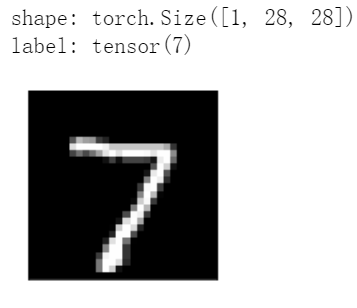

In [ ]:
#torchvision 库是服务于pytorch深度学习框架的,用来生成图片,视频数据集,和一些流行的模型类和预训练模型
#可以调用torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)来下载MNIST数据集
#参数root代表存放数据集的根目录
#参数train代表是否为训练数据集
#参数Transform代表一个函数/转换，它接收PIL图像并返回转换后的版本。这里我们pytorch框架中只接收tensor类型数据，所以需要进行转换
#参数download如果为true，则从Internet下载数据集并将其放在根目录中。如果已下载数据集，则不会再次下载

In [ ]:
import torch.utils.data as Data #加载数据用
#在使用上面的torchvision.datasets调用完数据集后，再使用torch.utils.data的DataLoader方法来将数据集划分为许多batch，下面是三个主要参数
#dataset： 加载数据的数据集。
#batch_size：每个batch加载多少个样本(默认: 1)。
#shuffle：设置为True时会在每个epoch重新打乱数据(默认: False).

**<font color = blue size=4>第二部分:实验任务</font>**

任务1：使用LeNet网络训练MNIST数据集，保存每轮epoch中每个batch的训练损失以及每次网络更新后在测试集上的准确率，之后分别作两张图来将数据可视化。神经网络构建后，通过超参数的调整尽可能获得更高的准确率。

In [1]:
import torch
import torchvision
import matplotlib.pyplot as  plt
import torch.nn  as  nn
import torch.utils.data as Data 
import torch.nn.functional as F

搭建LeNet神经网络

LeNet实现：  
输入层：输入为28x28x1  
卷积层1：卷积核大小：5x5；输出大小：28x28x6 （为了保证输入和输出大小一致，所以这里需要加入填充）  
最大池化层1：卷积核大小：2x2；步幅大小：2；输出大小：14x14x6    
卷积层2：卷积核大小：5x5；输出大小：10x10x16  
最大池化层2：卷积核大小：2x2；步幅大小：2；输出大小：5x5x16  
全连接层1：输入大小：5x5x16；输出大小：120  
全连接层2：输入大小：120；输出大小：84  
全连接层3：输入大小：84；输出大小：10

计算图如下：
input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d  
     -> linear -> relu -> linear -> relu -> linear

In [2]:

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1,6,5,1,2)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    # 定义前向传播过程，输入为x
    def forward(self, x):
        
        x = self.pool1(F.relu(self.conv1(x)))
        
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net=LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


设置超参数，包括训练轮数，批次大小，学习率

In [3]:
epoch = 10
batch = 100
rate = 0.01

定义该次网络训练中需要使用的损失函数和优化方法

In [4]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=rate)

构建MNIST数据集，并按照训练批次大小完成训练集和测试集的划分

In [5]:

train_dataset = torchvision.datasets.MNIST(root='mnist_data', train=True, transform=torchvision.transforms.ToTensor(), target_transform=None, download=False)
test_dataset = torchvision.datasets.MNIST(root='mnist_data', train=False, transform=torchvision.transforms.ToTensor(), target_transform=None, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch)

开始训练完成并更新，保存每轮中每个batch的训练损失，以及每轮网络更新后的准确率  
如果训练效果较差，可以对超参数以及神经网络进行适当调整

In [6]:


train_loss = []
test_loss = []
correct = []
for i in range(epoch):
    train_correct=0
    tem=0
    for img, label in train_loader:
        out = net(img)
        loss=criterion(out,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tem+=loss 
        _, m = out.max(1)    
        num_correct = (m == label).sum().item()  
        acc = num_correct / img.shape[0]
        train_correct += acc
    train_loss.append(tem / len(train_loader))
    correct.append(train_correct / len(train_loader))
    
    
    tem = 0
    for img, label in test_loader:
        out = net(img)
        loss = criterion(out, label)
        
 
        tem += loss
    test_loss.append(tem / len(test_loader))
    



利用上次实验中的画图方法将训练损失和准确率进行作图

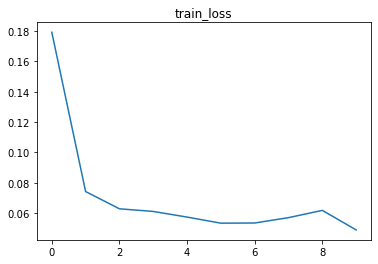

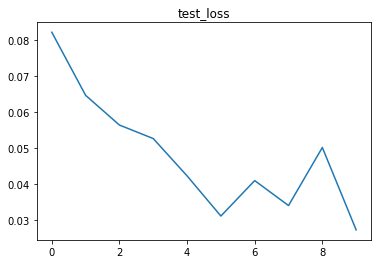

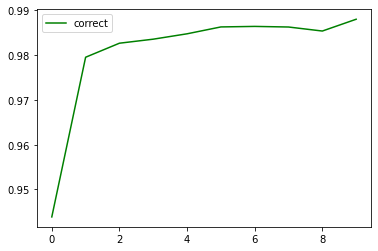

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  
# for i in range(len(train_loss)):
#     train_loss[i]=train_loss[i].detach().numpy()   /////也可以在训练时就转成numpy
# for i in range(len(test_loss)):
#     test_loss[i]=test_loss[i].detach().numpy()
plt.title("train_loss")
plt.plot(np.arange(len(train_loss)), train_loss)
plt.show()
 
plt.title("test_loss")
plt.plot(np.arange(len(test_loss)), test_loss)
plt.show()

plt.plot(np.arange(len(correct)),correct,color='green',label='correct')
plt.legend()
plt.show()

任务2：Alexnet较为复杂，训练时间长，感兴趣的同学可以课后尝试训练，这里不做要求训练。只要求写出网络结构的代码。

AlexNet实现：  
输入层：输入为28x28x1  
卷积层1：卷积核大小：3x3；输出大小：28x28x32 （为了保证输入和输出大小一致，所以这里需要加入填充）  
最大池化层1：卷积核大小：2x2；步幅大小：2；输出大小：14x14x32  
ReLu1  
卷积层2：卷积核大小：3x3；输出大小：14x14x64 （为了保证输入和输出大小一致，所以这里需要加入填充）  
最大池化层2：卷积核大小：2x2；步幅大小：2；输出大小：7x7x64   
ReLu2  
卷积层3：卷积核大小：3x3；输出大小：7x7x128 （为了保证输入和输出大小一致，所以这里需要加入填充）  
卷积层4：卷积核大小：3x3；输出大小：7x7x256 （为了保证输入和输出大小一致，所以这里需要加入填充）  
卷积层5：卷积核大小：3x3；输出大小：7x7x256 （为了保证输入和输出大小一致，所以这里需要加入填充）  
最大池化层3：卷积核大小：2x2；步幅大小：2；输出大小：3x3x256   
ReLu3   
全连接层1：输入大小：3x3x256；输出大小：1024    
全连接层2：输入大小：1024；输出大小：512    
全连接层3：输入大小：512；输出大小：10

In [11]:
import torch.nn.functional as F
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.conv1 = nn.Conv2d(1,32,3,1,1)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(32,64,3,1,1)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv3 = nn.Conv2d(64,128,3,1,1)
        self.conv4 = nn.Conv2d(128,256,3,1,1)
        self.conv5 = nn.Conv2d(256,256,3,1,1)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(3*3*256, 1024)  
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
    def forward(self,x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.pool3(F.relu(x))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net=AlexNet()
print(net)

AlexNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


**<font color = blue size=4>第三部分:作业提交</font>**

一、实验课下课前提交完成代码，如果下课前未完成，请将已经完成的部分进行提交，未完成的部分于之后的实验报告中进行补充  
要求:  
1)文件格式为：学号-姓名.ipynb  
2)【不要】提交文件夹、压缩包、数据集等无关文件，只需提交单个ipynb文件即可，如果交错请到讲台前联系助教，删掉之前的错误版本后再进行提交

二、本次实验分两周完成，所以实验报告于下下周五实验课(6月10号前)上课前提交报告  
要求：  
1)文件格式为：学号-姓名.pdf  
2)【不要】提交文件夹、压缩包、代码文件、数据集等任何与实验报告无关的文件，只需要提交单个pdf文件即可  
3)文件命名时不需要额外添加“实验几”等额外信息，按照格式提交  
4)每周的实验报告提交地址会变化，且有时间限制，提交时间为下周的实验课开始时，请注意及时提交。

实验十(卷积网络)的实验报告上交地址:https://workspace.jianguoyun.com/inbox/collect/998b6c0c23d04152bcd41a7760e595cc/submit

三、课堂课件获取地址:https://www.jianguoyun.com/p/DQlpUFYQp5WhChiS_q0E  
实验内容获取地址:https://www.jianguoyun.com/p/DbKbP-AQp5WhChi1sa0E